In [1]:
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
import cv2
import math
#https://pypi.org/project/python-mnist
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
delta = 1e-8
l = len(images)
n = len(images[0])
m = int(np.sqrt(n))

m_p = int(m )
m_q = int(m / 2)

n_p = m_p*m_p
n_q = m_q*m_q

def random_mnist(n_p, n_q):
    p, q = np.random.randint(l), np.random.randint(l)
    p, q = np.float64(images[p]), np.float64(images[q])
    
    p, q = cv2.resize(p.reshape(-1, m), (n_p, n_p)), cv2.resize(q.reshape(-1, m), (n_q, n_q))
    #p, q = cv2.resize(p, (n_p, n_p)), cv2.resize(q, (n_q, n_q))
    
    
    p, q = p.reshape(-1), q.reshape(-1)
    #p[p < delta] = delta
    #q[q < delta] = delta
    return p / sum(p)  , q / sum(q)

p, q = random_mnist(m_p, m_q)

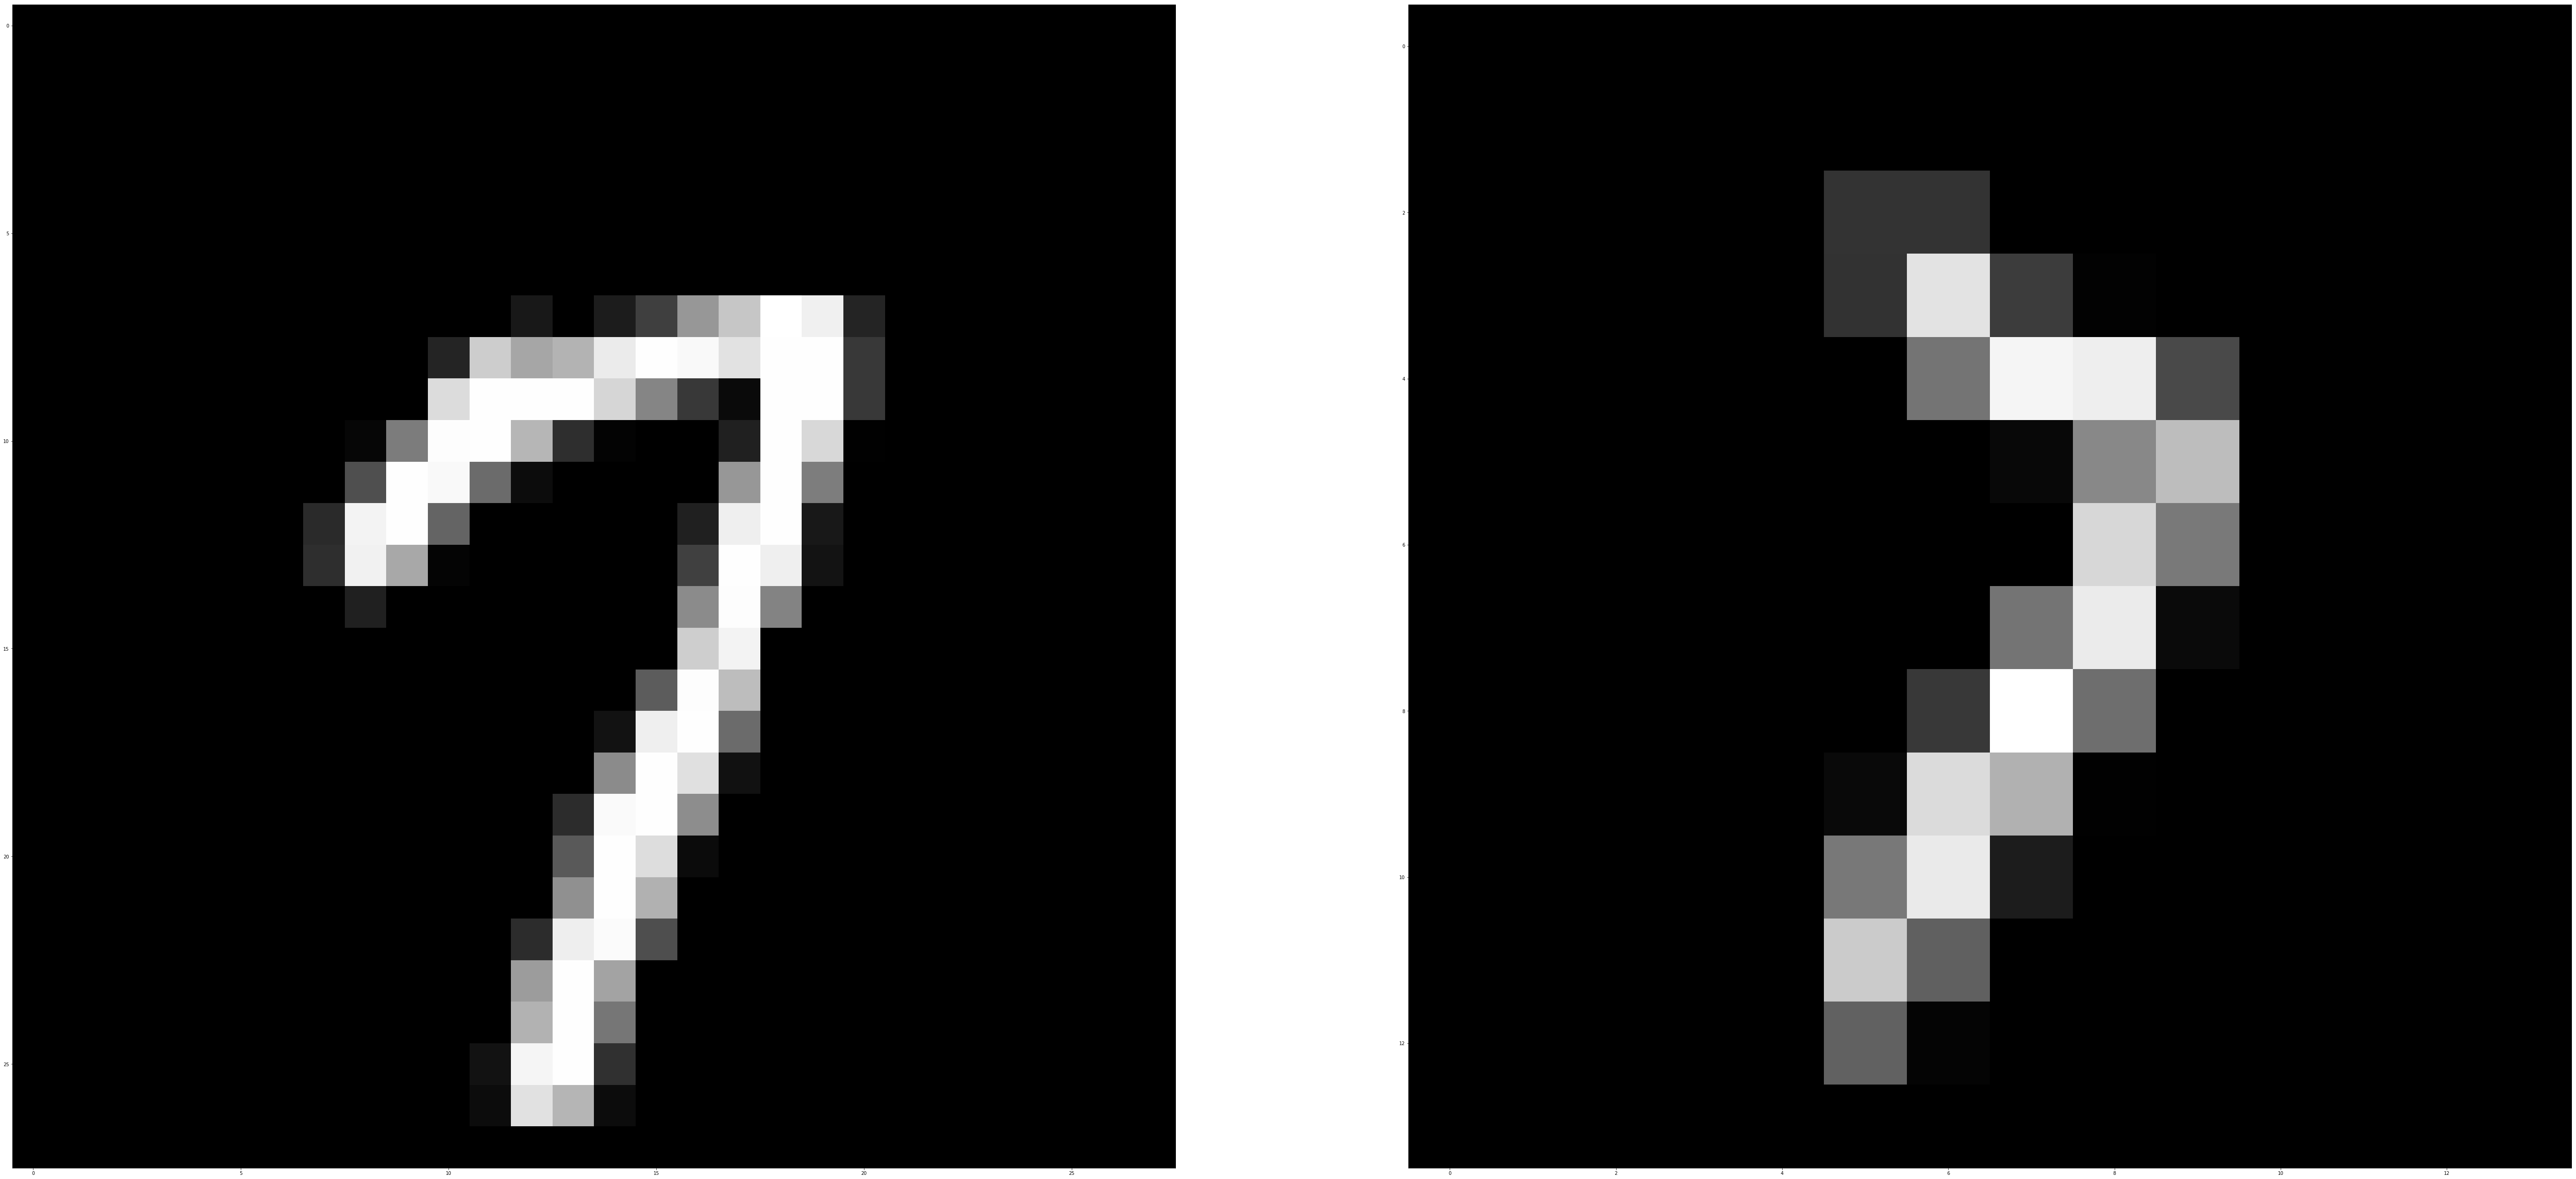

In [3]:
plt.figure(figsize=(100,100))

plt.subplot(121)
plt.imshow(p.reshape(-1, m_p), cmap=plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(q.reshape(-1, m_q), cmap=plt.get_cmap('gray'))


In [4]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

C = np.arange(m_p)
C = cartesian_product(C, C)
C = cdist(C, C)
C[C==0] = 1e-1
C /= C.max()
C.max()
C = C[:n_p, :n_q]

In [5]:
one_n_p = np.ones(n_p, np.float64)
one_n_q = np.ones(n_q, np.float64)
I = np.ones([n_p,n_q], np.float64)

def f_true(x):
    return (C * x).sum()

def mround(x):
    x += 1e-25
    r = p / x.dot(one_n_q)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q / (x.T).dot(one_n_p)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p - F.dot(one_n_q)
    err_c = q - (F.T).dot(one_n_p)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [6]:
import copy
from numpy import linalg
from scipy import stats
import time

eps = 1e-2
gamma = eps/3/np.log(n)

eps_f = eps   #function accuracy

In [7]:
def f_(x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    y = y.reshape(n_p, -1)

    p_hat = x.dot(one_n_q)
    q_hat = x.T.dot(one_n_p)

    p_mask = p_hat == 0
    q_mask = q_hat == 0

    p_hat[p_mask] = p[p_mask]
    q_hat[q_mask] = q[q_mask]

    return (p_hat * (np.log(p_hat/p))).sum() + (q_hat * (np.log(q_hat/q)).sum() + gamma * x * np.log(y)).sum()

def x_(u, v):
    x_star = np.exp((-C - np.outer(u, one_n_q) - np.outer(one_n_p, v)) / gamma)
    return x_star

def phi_(uv):
    x_star = x_(uv[:n_p], uv[n_p:])
    return (np.exp(uv[:n_p]) - one_n_p).dot(p) + (np.exp(uv[n_p:]) - one_n_q).dot(q) + gamma * x_star.sum()
                    
def grad_phi_(uv):
    x_star = x_(uv[:n_p], uv[n_p:])
    return np.concatenate((np.exp(uv[:n_p]) * p - x_star.dot(one_n_q), np.exp(uv[n_p:]) * q - x_star.T.dot(one_n_p)), 0), x_star

def phi_1d_(x, e):
    def f1d(h):
        return phi_(x + h * e)
    return f1d

def grad_phi_1d_(x, e):
    def gradf1d(h):
        return np.array(grad_phi_(x + h * e)[0].dot(e))
    return gradf1d

def phi_grad_phi_(uv):
    x_star = x_(uv[:n_p], uv[n_p:])
    return (np.exp(uv[:n_p]) - one_n_p).dot(p) + (np.exp(uv[n_p:]) - one_n_q).dot(q) + gamma * x_star.sum(), np.concatenate((np.exp(uv[:n_p]) * p - x_star.dot(one_n_q), np.exp(uv[n_p:]) * q - x_star.T.dot(one_n_p)), 0)

def phi_grad_phi_1d_(x, e):
    def fgradf1d(h):
        uv = x + h * e
        x_star = x_(uv[:n_p], uv[n_p:])
        return (np.exp(uv[:n_p]) - one_n_p).dot(p) + (np.exp(uv[n_p:]) - one_n_q).dot(q) + gamma * x_star.sum(), np.array(np.concatenate((np.exp(uv[:n_p]) * p - x_star.dot(one_n_q), np.exp(uv[n_p:]) * q - x_star.T.dot(one_n_p)), 0).dot(e))
    return fgradf1d    

# 1802.04367

In [8]:
def APDAGD(wtime):
    L = 1.
    betta = alpha = 0.
    x_hat = np.zeros([n_p, n_q], np.float64)
    z = np.zeros(n_p + n_q, np.float64)
    z_new = np.zeros(n_p + n_q, np.float64)
    eta = np.zeros(n_p + n_q, np.float64)
    eta_new  = np.zeros(n_p + n_q, np.float64)
    k=0
    phis = []
    xs = []
    times = []
    start_time = time.perf_counter()
    while True:
        L = L / 2
        while True:
            alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
            betta_new = betta + alpha_new
            tau = alpha_new / betta_new
            uv_new = tau * z + (1 - tau) * eta
            
            #phi_new, grad_phi_new = phi_grad_phi_(uv_new)
            x_star = x_(uv_new[:n_p], uv_new[n_p:])
            phi_new = (np.exp(uv_new[:n_p]) - one_n_p).dot(p) + (np.exp(uv_new[n_p:]) - one_n_q).dot(q) + gamma * x_star.sum()
            
            grad_phi_new = np.concatenate((np.exp(uv_new[:n_p]) * p - x_star.dot(one_n_q), np.exp(uv_new[n_p:]) * q - x_star.T.dot(one_n_p)), 0)
            
            z_new = z - alpha_new * grad_phi_new
            eta_new = tau * z_new + (1-tau) * eta
            phi_eta = phi_(eta_new)
            if phi_eta <= phi_new + grad_phi_new.dot(eta_new - uv_new) + L * ((eta_new - uv_new)**2).sum() / 2:
                alpha, betta = alpha_new, betta_new
                z = z_new.copy()
                eta = eta_new.copy()
                break    
            L = L * 2
            del uv_new, grad_phi_new, phi_eta
        x_hat = tau * x_star + (1 - tau) * x_hat
        xs.append(x_hat)
        phis.append(phi_new)    
        del phi_new
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        if (ctime > wtime):
            break
        k=k+1
    return np.array(phis), np.array(xs), np.array(times), k

# 1809.05895 

In [9]:
def universal(f_, grad_f_, f_grad_f_, x, eps):
    L = 1.
    betta = alpha = 0.
    n = x.shape[0]
    while True:
        L = L / 2
        while True:
            f_x, grad_f_x = f_grad_f_(x)
            x_new = x - grad_f_x / L
            dx = x_new - x
            f_x_new = f_(x_new)
            if f_x_new <= f_x + grad_f_x.dot(dx) + L * dx.dot(dx) / 2:
                break    
            else:
                L = L * 2
        if(linalg.norm(grad_f_(x_new)) < eps):
            return x_new, f_x_new
        x = x_new.copy()
        
def binary(f_, grad_f_, h_0, max_steps, eps):
    step = 0.1
    f1 = f_(h_0)
    i = 0
    a_k = h_0
    while (i < max_steps):
        f2 = f_(h_0 + step)
        if (f1 < f2):
            break
        else:
            f1 = f2
            h_0 = h_0 + step
        i += 1
    tau = (math.sqrt(5) + 1)/2
    if h_0 == h_0:
        a_k = 0
    else:
        a_k = h_0 - 4*step
    
    b_k = h_0
    
    N_min = math.floor(math.log((b_k - a_k)/eps, tau)) + 1
    y_k = a_k + (b_k - a_k)/tau/tau
    z_k = a_k + (b_k - a_k)/tau
    current = f_(y_k)
    IsNextZ = 1
    h = y_k
    k = 1
    while (k < N_min):
    #while True:
        if (IsNextZ == 1):
            new = f_(z_k)
            if (current <= new):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                IsNextZ = 0
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                current = new
                h = z_k
        elif (IsNextZ == 0):
            new = f_(y_k)
            if (new <= current):
                b_k = a_k + (b_k - a_k)/tau
                z_k = y_k
                y_k = a_k + (b_k - a_k)/tau/tau
                current = new
                h = y_k
            else:
                a_k = y_k
                y_k = z_k
                z_k = a_k + (b_k - a_k)/tau
                IsNextZ = 1
        if(linalg.norm(grad_f_(h)) < eps):
            break
        k += 1 
    return h

def binary_ab(f, xleft, xright, eps_search):
    N = math.floor(np.log2(abs(xright - xleft)/eps_search)) + 1
    k=0
    a = xleft + (xright - xleft)/4
    b = xleft + (xright - xleft)/2
    fa = f(a)
    fb = f(b)
    fleft = f(xleft)
    fright = f(xright)
    while fb - fa > eps_search or k < N:
        #print(fa, fb)
        if fa > fb:
            fleft = fa
            xleft = a
        elif fb > fa:
            fright = fb
            xright = b
        else:
            break
        k+=1
    
        a = xleft + (xright - xleft)/4
        b = xleft + (xright - xleft)/2
        fa = f(a)
        fb = f(b)
        
    #return xleft, fleft
    
    minf = min(fleft, fa, fb, fright)
    if minf == fleft:
        return xleft, fleft
    elif minf == fa:
        return a, fa
    elif minf == fb:
        return b, fb
    elif minf == fright:
        return xright, fright, 

def binary_n(f, x0, N, eps_search):
    xleft = 0
    xright = x0
    
    fleft = f(xleft)
    fright = f(xright)
    k = 0
    while k < N:
        if fleft < fright:
            break
        else:
            fleft = fright
            xleft = xright
            xright *= 2
            fright = f(xright)
        k+=1

    if xleft == x0:
        xleft = 0
    else:
        xleft /= 4
        
    #fleft < fright
    N = math.floor(np.log2(abs(xright - xleft)/eps_search)) + 1
    
    return binary_ab(f, xleft, xright, eps_search)

In [10]:
def AGMsDR(wtime, eps_search, design='u'):
    A = 0.
    x = np.zeros(n_p + n_q, np.float64)
    v = x.copy()
    psi_A = 0.5
    psi_b = x.copy()
    k=0
    primal_mean = np.zeros([n_p, n_q], np.float64)
    phis = []
    primals = []
    times = []
    start_time = time.perf_counter()
    beta = 0 
    while True:
        if k == 0:
            beta=0
        else:
            beta, _ = binary_ab(phi_1d_(v, x - v), 0, 1, 1e-3)
        f_y = phi_1d_(v, x - v)(beta)
        #beta, f_y =  universal(phi_1d_(v, x-v), grad_phi_1d_(v, x-v), phi_grad_phi_1d_(v, x-v), np.zeros(1, np.float64), 0.000001)
        y = v + beta * (x - v)
        grad_f_y, primal_var = grad_phi_(y)
        
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        
        if design == 'u':
            h, f_x =  universal(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), phi_grad_phi_1d_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), 1e-1, 100, eps_search)
            f_x = phi_1d_(y, -grad_f_sharp)(h)
        
        x = y - h * grad_f_sharp
        g, a = (f_x - f_y), norm_grad_f_y**2
        alpha = (-g + np.sqrt(g*g - 2*a*g*A)) / a 
        A = A + alpha
        psi_b = psi_b + alpha * (grad_f_y)
        v = -psi_b / psi_A
        k = k + 1
        primal_mean += alpha * primal_var
        if A != 0:
            primals.append(primal_mean / A)
        else:
            primals.append(1e-8 * np.ones([n_p, n_q], np.float64))
        phis.append(f_x)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        if (ctime > wtime):
            break
    return np.array(phis), np.array(primals),  np.array(times), k


def UAGMsDR(wtime, eps_search, eps_f, design='u'):
    k = 0
    x = np.zeros(n_p + n_q, np.float64)
    v = copy.deepcopy(x)
    A = 0
    primal_mean = np.zeros([n_p, n_q], np.float64)
    phis = []
    primals = []
    times = []
    start_time = time.perf_counter()
    while True:
        beta, _ = binary_ab(phi_1d_(v, x - v), 0, 1, 1e-3)
        f_y = phi_1d_(v, x - v)(beta)
        y = v + beta*(x - v)
        
        grad_f_y, primal_var = grad_phi_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        
        if design == 'u':
            h, f_x =  universal(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), phi_grad_phi_1d_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), eps_search)
        else:
            h =  binary(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), 1e-1, 100, eps_search)
            f_x = phi_1d_(y, -grad_f_sharp)(h)
        x = y - h*grad_f_sharp
        
        const = (f_y - f_x + eps_f/2)
        alpha = (const + (const**2 + 2*(const-eps_f/2)*A*(norm_grad_f_y**2))**0.5)/(norm_grad_f_y**2)
        A += alpha
        v -= alpha * grad_f_y
        k += 1
        primal_mean += alpha * primal_var
        
        if A != 0:
            primals.append(primal_mean / A)
        else:
            primals.append(1e-8 * np.ones([n_p, n_q], np.float64))
        phis.append(f_x)
        ctime = time.perf_counter() - start_time
        times.append(ctime)
        if (ctime > wtime):
            break
    return np.array(phis), np.array(primals), np.array(times), k

# APDAGD vs AGM vs UAGM | $x \in \mathbb R^{n^2}_+$

In [11]:
wtime = 15
eps_search = 1e-3
eps_f=1e-2

In [12]:
phis1, xs1, times1, N1 = APDAGD(wtime)

In [13]:
phis2, xs2, times2, N2 = AGMsDR(wtime, eps_search, design='b')

In [14]:
phis3, xs3, times3, N3 = UAGMsDR(wtime, eps_search, eps_f, design='b')

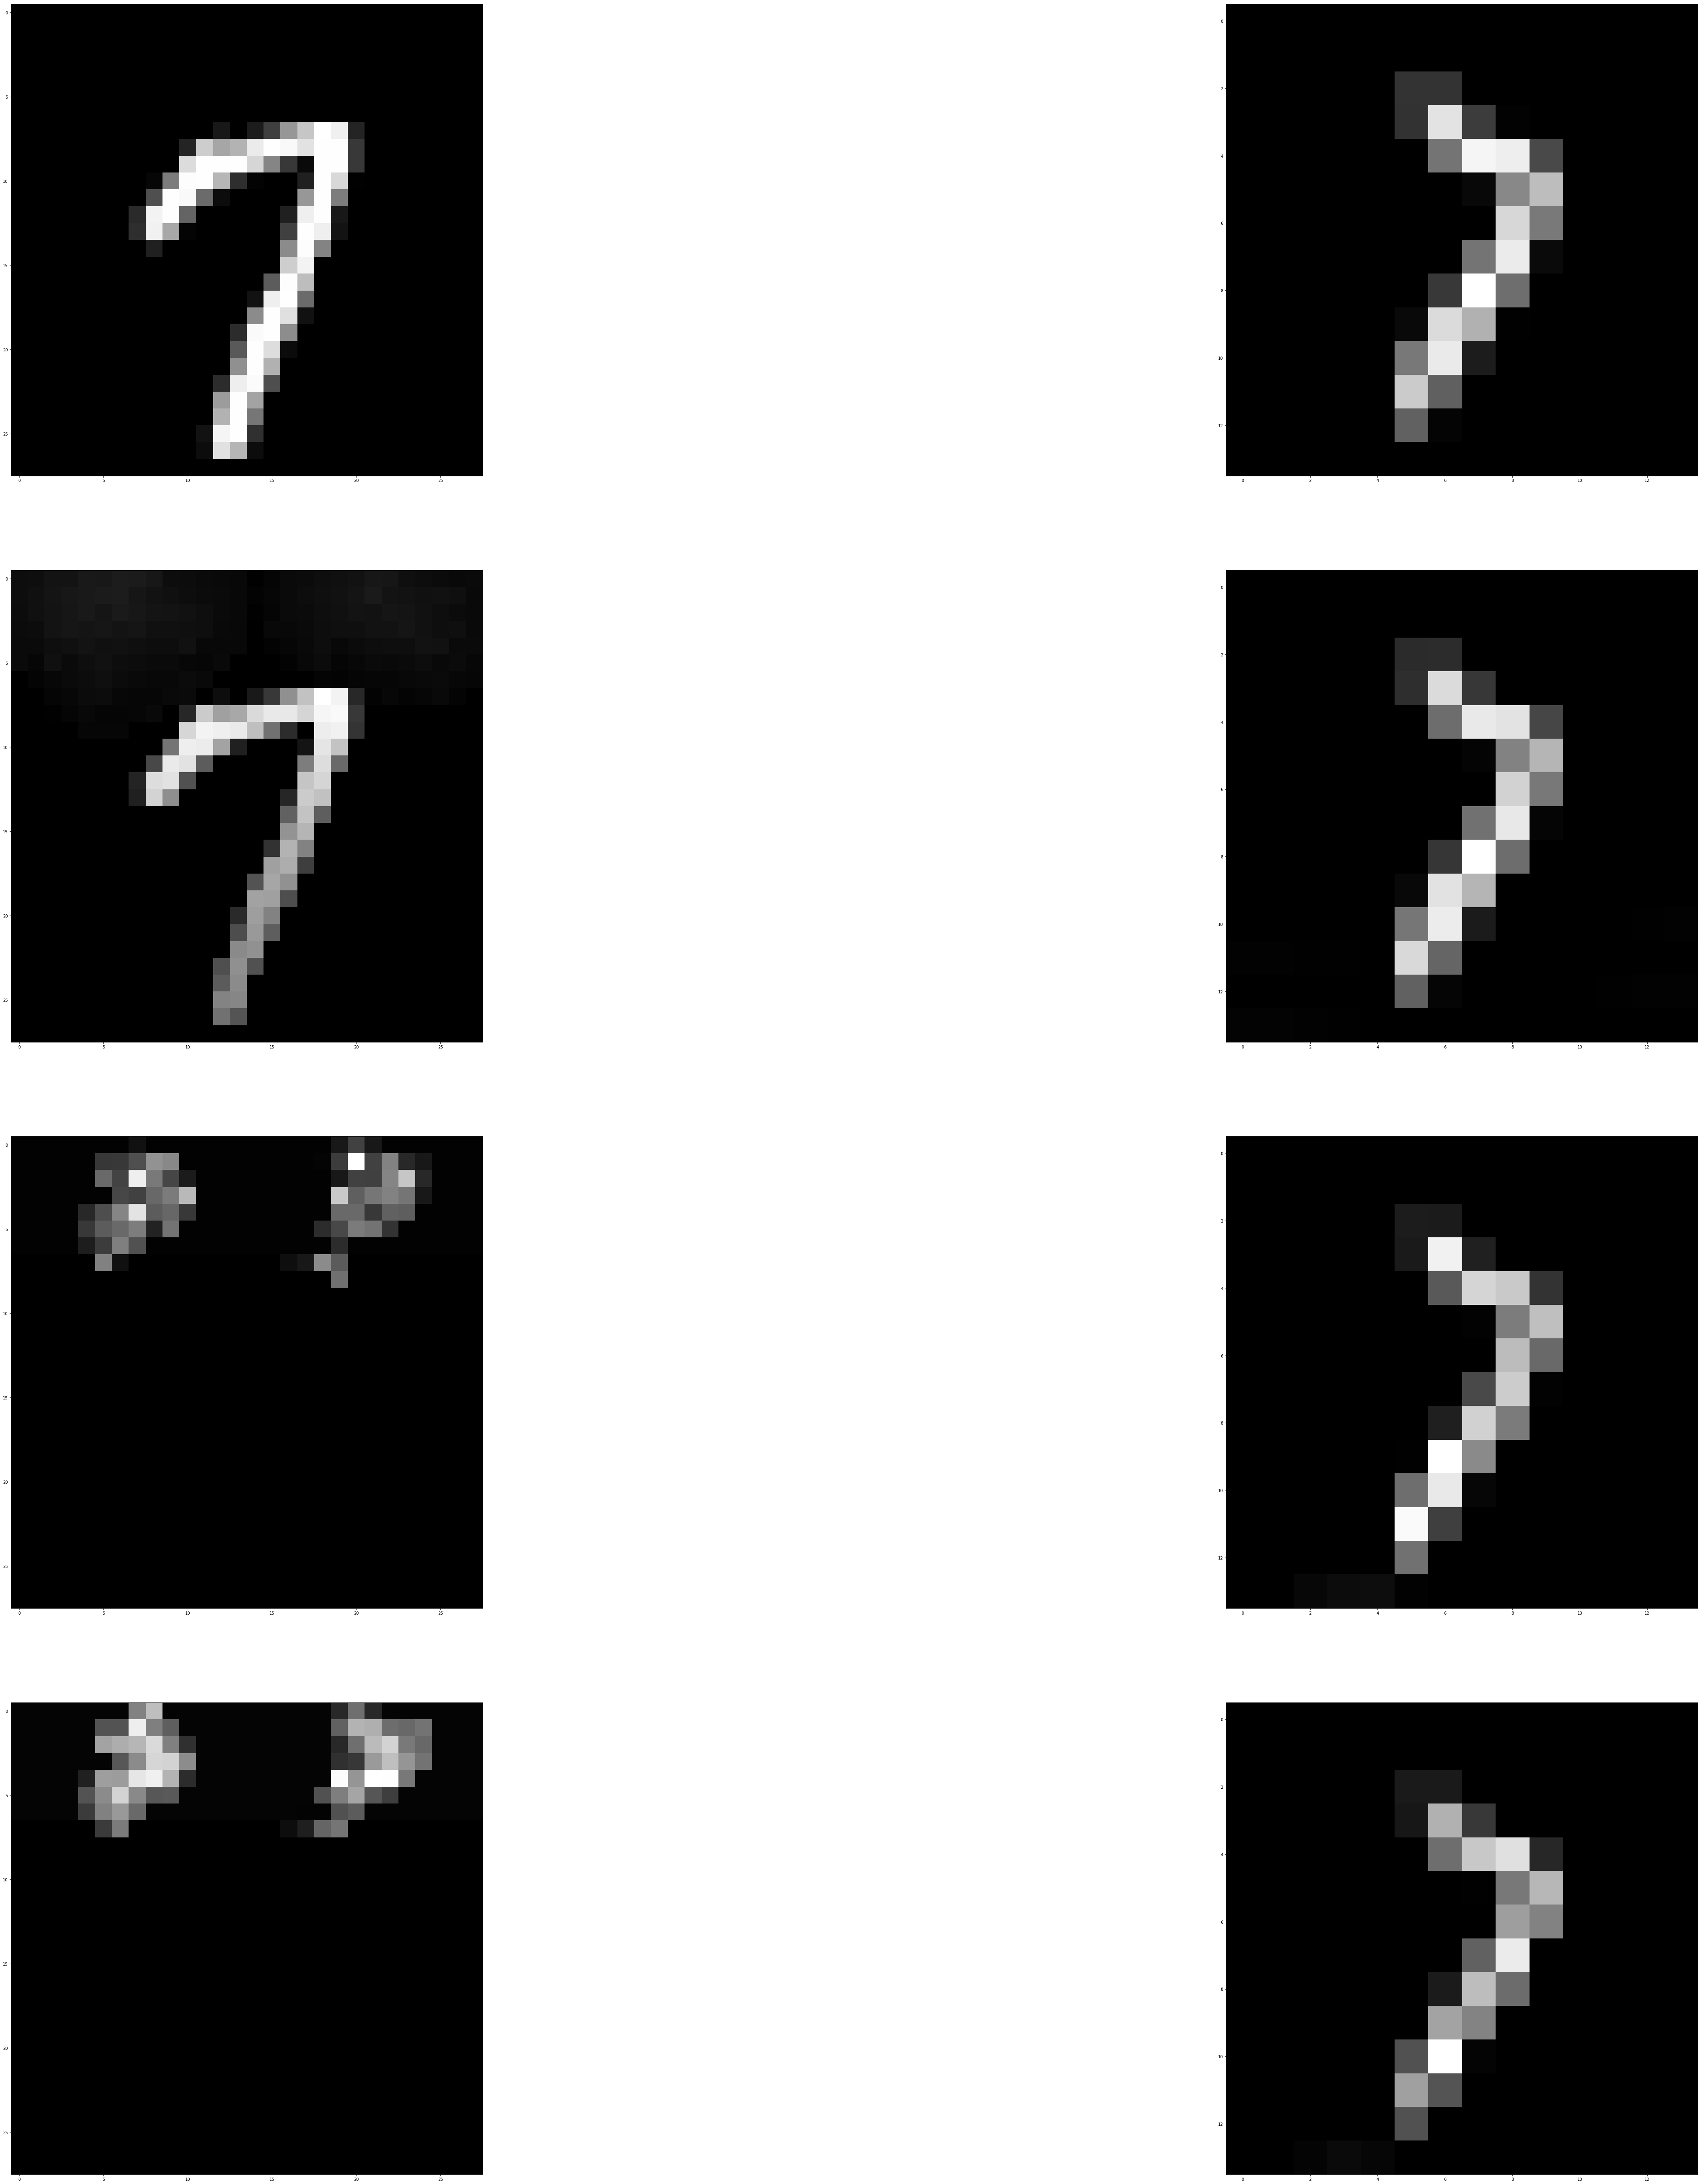

In [15]:
plt.figure(figsize=(100,100))

plt.subplot(421)
plt.imshow(p.reshape(-1, m_p), cmap=plt.get_cmap('gray'))
plt.subplot(422)
plt.imshow(q.reshape(-1, m_q), cmap=plt.get_cmap('gray'))

plt.subplot(423)
plt.imshow(xs1[-1].dot(one_n_q).reshape(-1, m_p), cmap=plt.get_cmap('gray'))
plt.subplot(424)
plt.imshow(xs1[-1].T.dot(one_n_p).reshape(-1, m_q), cmap=plt.get_cmap('gray'))

plt.subplot(425)
plt.imshow(xs2[-1].dot(one_n_q).reshape(-1, m_p), cmap=plt.get_cmap('gray'))
plt.subplot(426)
plt.imshow(xs2[-1].T.dot(one_n_p).reshape(-1, m_q), cmap=plt.get_cmap('gray'))

plt.subplot(427)
plt.imshow(xs3[-1].dot(one_n_q).reshape(-1, m_p), cmap=plt.get_cmap('gray'))
plt.subplot(428)
plt.imshow(xs3[-1].T.dot(one_n_p).reshape(-1, m_q), cmap=plt.get_cmap('gray'))

In [16]:
N = min(N1, N2, N3)

### Dual Objective vs. Iterations

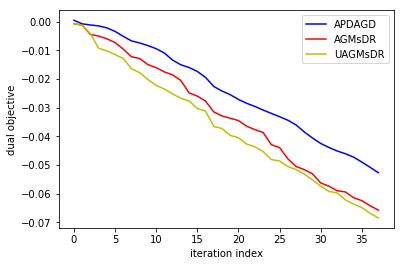

In [17]:
begin = 0
x = range(begin, N)
fig, ax = plt.subplots()
ax.plot(x, phis1[begin:N], '-b', label='APDAGD')
ax.plot(x, phis2[begin:N], '-r', label='AGMsDR')
ax.plot(x, phis3[begin:N], '-y', label='UAGMsDR')
ax.set_xlabel('iteration index')
ax.set_ylabel('dual objective')
leg = ax.legend();

In [18]:
ft1 = np.array([f_true(i) for i in xs1[:]])
ft2 = np.array([f_true(i) for i in xs2[:]])
ft3 = np.array([f_true(i) for i in xs3[:]])

### Non-Regularized Primal vs. Iterations

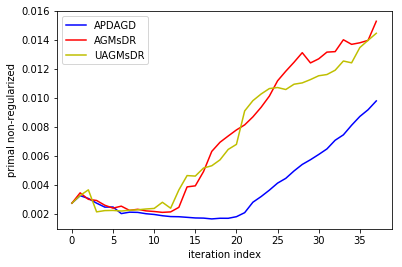

In [19]:
begin = 0
x = range(begin, N)
fig, ax = plt.subplots()
ax.plot(x, ft1[begin:N], '-b', label='APDAGD')
ax.plot(x, ft2[begin:N], '-r', label='AGMsDR')
ax.plot(x, ft3[begin:N], '-y', label='UAGMsDR')
ax.set_xlabel('iteration index')
ax.set_ylabel('primal non-regularized')
leg = ax.legend();

### Constraints Residual vs. Iterations

In [20]:
r1 = np.array([np.linalg.norm(i.dot(one_n_q) - p, 1) + np.linalg.norm(i.T.dot(one_n_p) - q, 1) for i in xs1[:]])
r2 = np.array([np.linalg.norm(i.dot(one_n_q) - p, 1) + np.linalg.norm(i.T.dot(one_n_p) - q, 1) for i in xs2[:]])
r3 = np.array([np.linalg.norm(i.dot(one_n_q) - p, 1) + np.linalg.norm(i.T.dot(one_n_p) - q, 1) for i in xs3[:]])

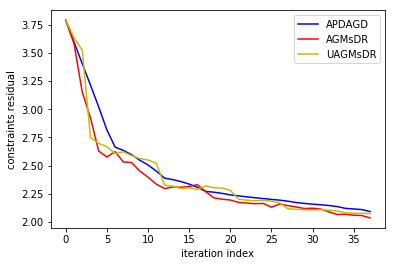

In [21]:
begin = 0
x = range(begin, N)
fig, ax = plt.subplots()
ax.plot(x, r1[begin:N], '-b', label='APDAGD')
ax.plot(x, r2[begin:N], '-r', label='AGMsDR')
ax.plot(x, r3[begin:N], '-y', label='UAGMsDR')
ax.set_xlabel('iteration index')
ax.set_ylabel('constraints residual')
leg = ax.legend();

### Non-regularized Primal vs. Iteration with Rounding

In [22]:
fr1 = np.array([f_true(mround(i)) for i in xs1])
fr2 = np.array([f_true(mround(i)) for i in xs2])
fr3 = np.array([f_true(mround(i)) for i in xs3])

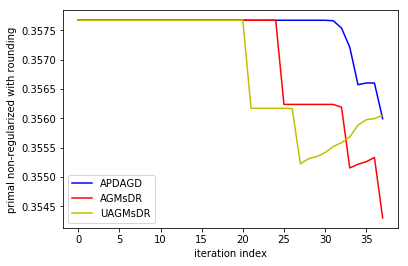

In [23]:
begin = 0
x = range(begin, N)
fig, ax = plt.subplots()
ax.plot(x, fr1[begin:N], '-b', label='APDAGD')
ax.plot(x, fr2[begin:N], '-r', label='AGMsDR')
ax.plot(x, fr3[begin:N], '-y', label='UAGMsDR')
ax.set_xlabel('iteration index')
ax.set_ylabel('primal non-regularized with rounding')
leg = ax.legend();

### Dual Objectives vs. Time

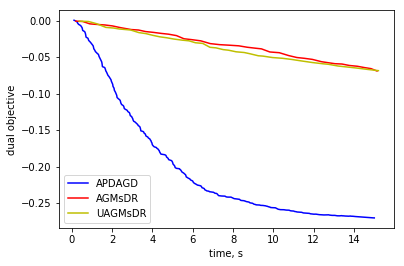

In [24]:
begin=0
fig, ax = plt.subplots()

mask1 = (times1 > begin)
mask2 = (times2 > begin)
mask3 = (times3 > begin)

ax.plot(times1[mask1], phis1[mask1], '-b', label='APDAGD')
ax.plot(times2[mask2], phis2[mask2], '-r', label='AGMsDR')
ax.plot(times3[mask3], phis3[mask3], '-y', label='UAGMsDR')
ax.set_xlabel('time, s')
ax.set_ylabel('dual objective')
leg = ax.legend();

### Constraints Residual vs. Time

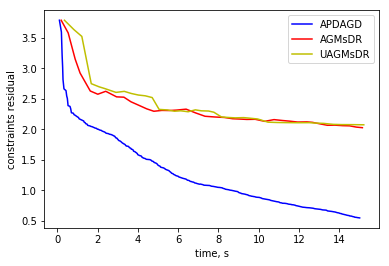

In [25]:
begin=0

mask1 = (times1 > begin)
mask2 = (times2 > begin)
mask3 = (times3 > begin)

fig, ax = plt.subplots()
ax.plot(times1[mask1], r1[mask1], '-b', label='APDAGD')
ax.plot(times2[mask2], r2[mask2], '-r', label='AGMsDR')
ax.plot(times3[mask3], r3[mask3], '-y', label='UAGMsDR')
ax.set_xlabel('time, s')
ax.set_ylabel('constraints residual')
leg = ax.legend();